In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing as preproc

import random
import math
import time

In [2]:
#GREEDY

def init_array(n, k):
    a = [i for i in range (k)]
    for i in range (k,n):
        a.append(i%k)

    random.shuffle(a)
    return a

#globalna promenljiva za odabir rastojanja
distType = 'euclid'

def distance(i1 ,i2):
    if distType == 'euclid':
        #Euclid                
        squared_coord_diff_sum = 0    
        for field in i1._fields:        
            if field == "Index" or field == "Clusters":
                continue            
            else:
                squared_coord_diff = (getattr(i1, field) - getattr(i2, field))**2
                squared_coord_diff_sum = squared_coord_diff_sum + squared_coord_diff    
        distance = math.sqrt(squared_coord_diff_sum)                        
        return distance

    elif distType == 'manhattan':
        #manhattan distance
        total = 0
        for field in i1._fields:        
            if field == "Index" or field == "Clusters":
                continue            
            else:
                total  += abs(getattr(i1, field) - getattr(i2, field))

        return total


def calculateSum(data, cluster_num):
    sum = 0    
    for cl in range(0,cluster_num):

        cluster_data = data.loc[data["Cluster"] == cl]        
        cluster_sum = 0

        #distanca medju instancama u jednom klasteru
        #iteriramo kroz parove redova u klasteru sa poretkom da ne bismo ponavljali parove
        for namedTuple1 in cluster_data.itertuples():
            for namedTuple2 in cluster_data.itertuples():
                if(namedTuple1[0] < namedTuple2[0]):
                    cluster_sum = cluster_sum + distance(namedTuple1, namedTuple2)

        sum = sum + cluster_sum    
    
    return sum


def greedy_algorithm(data, cluster_num, init_sum):
    
    current_best_sum = init_sum
    best_swap = None
    best_swap_improvment = 0

    while True:

        #iteracija kroz parove klastera
        for cl1 in range(0,cluster_num):
            for cl2 in range(0,cluster_num):
                if(cl1 < cl2):

                    data_tmp = None

                    #uzmemo insance iz prvog klastera
                    cluster1_data = data.loc[data["Cluster"] == cl1]

                    #prodjemo kroz njih
                    for i1 in cluster1_data.itertuples():                
                        #prebacimo ih u drugi klaster
                        data_tmp = data.copy()
                        data_tmp.loc[ i1.Index, "Cluster"] = cl2
                        new_swap_sum = calculateSum(data_tmp, cluster_num)

                        #proverimo novu sumu i ako je bolja od prethodno najbolje pamtimo je
                        if new_swap_sum < current_best_sum:
                            improvment = current_best_sum - new_swap_sum
                            if improvment > best_swap_improvment:
                                best_swap = (i1.Index, cl1, cl2)
                                best_swap_improvment = improvment

                    data_tmp = None

                    #uzmemmo instance iz drugog klastera
                    cluster2_data = data.loc[data["Cluster"] == cl2]

                    #prodjemo kroz njih
                    for i2 in cluster2_data.itertuples():                
                        #prebacimo ih u prvi klaster
                        data_tmp = data.copy()
                        data_tmp.loc[ i2.Index, "Cluster"] = cl1
                        new_swap_sum = calculateSum(data_tmp, cluster_num)

                        #proverimo novu sumu i ako je bolja od prethodno najbolje pamtimo je
                        if new_swap_sum < current_best_sum:
                            improvment = current_best_sum - new_swap_sum
                            if improvment > best_swap_improvment:
                                best_swap = (i2.Index, cl2, cl1)
                                best_swap_improvment = improvment

        #ako nismo nasli prebacivanje koje ce pobojsati sumu stajmo
        if best_swap == None:
            print('Gotovo!')
            break;

        #print("Podoljsanje: ", best_swap_improvment)

        #uradimo najbolje nadjeno prebacivanje
        data.loc[best_swap[0], "Cluster"] = best_swap[2]

        check_sum = calculateSum(data, cluster_num)

        #izrcunamo novu, trenutno najbolju sumu
        current_best_sum = current_best_sum - best_swap_improvment

        #provere radi: check_sum i current_best_sum trebaju biti isti
        #print("Provera: ", check_sum, current_best_sum)

        #cistimo 
        best_swap_improvment = 0
        best_swap = None

    result = current_best_sum
    return result


#ucitavanje podataka
data = pd.read_csv("./dogs.csv")
data = data.drop(columns='breed')

#unosa broja klastera
cluster_num = int(input('Broj klastera: '))

row_num = data.shape[0]

#ravnomerana inicijalizacija klstera
init_clusters = []
init_clusters = init_array(row_num,cluster_num)
np_init_clusters = np.array(init_clusters)
data["Cluster"] = np_init_clusters
print(data)

Broj klastera:  3


    height  weight  Cluster
0       19      45        1
1       12      20        2
2       18      35        0
3       29     120        2
4        8       8        1
5       22      78        1
6       23      70        1
7       32     160        0
8       21      50        0
9       19      65        0
10       6       7        2


In [3]:
#postavljamo rastojanje na euclid i inicijalizujemo sumu
distType = 'euclid'
init_sum = calculateSum(data, cluster_num)
print("Inicijalna suma: ", init_sum)

Inicijalna suma:  864.0233105498771


In [4]:
start_time = time.process_time()
resulting_sum = greedy_algorithm(data, cluster_num, init_sum)
end_time = time.process_time()

Gotovo!


In [5]:
#Zavrsno stanje
print("Inicijalna suma: ", init_sum)
print("Minimalna suma: ", resulting_sum)
print("Vreme izvrsavanja: ", end_time - start_time)

Inicijalna suma:  864.0233105498771
Minimalna suma:  319.6229092201534
Vreme izvrsavanja:  1.09375


In [6]:
#Silueta
from sklearn.metrics import  silhouette_score
siluette = silhouette_score(data.drop(columns='Cluster'), data['Cluster'].tolist())
print("Silueta: ", siluette)

Silueta:  0.5423733549698899


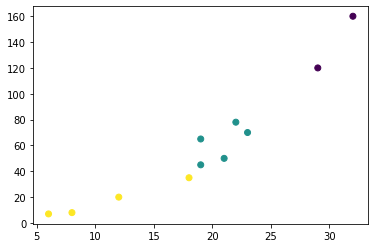

In [7]:
figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(data['height'].tolist(), data['weight'].tolist(), c = list(data['Cluster']))

In [8]:
#radimo ponovo inicijalizaciju klastera
init_clusters = []
init_clusters = init_array(row_num,cluster_num)
np_init_clusters = np.array(init_clusters)
data["Cluster"] = np_init_clusters

In [9]:
#postavljamo rastojanje na menhetn i inicijalizujemo sumu
distType = 'manhattan'
init_sum = calculateSum(data, cluster_num)
print("Inicijalna suma: ", init_sum)

Inicijalna suma:  873


In [10]:
start_time = time.process_time()
resulting_sum = greedy_algorithm(data, cluster_num, init_sum)
end_time = time.process_time()

Gotovo!


In [11]:
#Zavrsno stanje
print("Inicijalna suma: ", init_sum)
print("Minimalna suma: ", resulting_sum)
print("Vreme izvrsavanja: ", end_time - start_time)

Inicijalna suma:  873
Minimalna suma:  373
Vreme izvrsavanja:  1.0625


In [12]:
#Silueta
siluette = silhouette_score(data.drop(columns='Cluster'), data['Cluster'].tolist())
print("Silueta: ", siluette)

Silueta:  0.5423733549698899


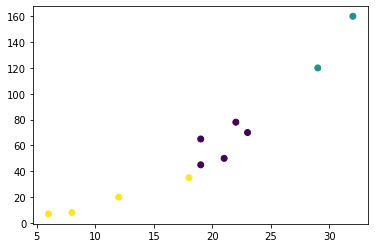

In [13]:
figure = plt.figure()
figure.add_subplot(1,1,1)
plt.scatter(data['height'].tolist(), data['weight'].tolist(), c = list(data['Cluster']))